In [1]:
# libraires for images and data
from PIL import Image
import re
import glob,os
from bs4 import BeautifulSoup
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

# libraries for deep learning
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
                                                                                                                                                                           
import logging
from Pegasus.api import *

from utils.wf import split_data_filenames, create_ann_list,create_augmented_filelist

In [1]:
import re
import glob,os
import pickle

import logging
from Pegasus.api import *

from utils.wf import split_data_filenames, create_ann_list,create_augmented_filelist

In [2]:
# When you restart the docker make sure to reinstall these:
#! sudo python3 -m pip install --upgrade pip
#! sudo python3 -m pip install --upgrade Pillow numpy torchvision matplotlib
#! sudo python3 -m pip install pandas torch bs4

#! sudo pip3 install opencv-python 
#! sudo pip3 install --upgrade setuptools
#! sudo pip3 install opencv-python 
#! sudo pip3 install optuna==2.0.0 
#! sudo pip3 install matplotlib 
#! sudo pip3 install torch
#! sudo pip3 install scikit-image
#! sudo pip3 install torchvision 
#! sudo pip3 install pytorchtools
#! sudo pip3 install joblib

In [2]:
# --- Import Pegasus API ---
from Pegasus.api import *
logging.basicConfig(level=logging.DEBUG)
props = Properties()
# set for checkpointing - if jobs fails or timeouts, Pegasus will retry the job 2 times
# and use the checkpoint to restart the job
props["dagman.retry"] = "1"
props["pegasus.transfer.arguments"] = "-m 1"
props.write()

In [3]:
# DATA AQUSITION
imagesList = glob.glob('data/images/*.png')
annotationList = glob.glob('data/annotations/*.xml')

NUM_TRIALS = 1
NUM_EPOCHS = 1

#DATA SPLIT
train_filenames,val_filenames,test_filenames, files_split_dict = split_data_filenames(imagesList)

#TODO: check the correctness of the fun
train_imgs, train_ann = create_ann_list(train_filenames)
val_imgs, val_ann     = create_ann_list(val_filenames)
test_imgs, test_ann   = create_ann_list(test_filenames)

In [4]:
#add images from group data
rc = ReplicaCatalog()

inputFiles = []
for img in imagesList:
    fileName = img.split("/")[-1]
    img_file = File(fileName)
    inputFiles.append(img_file)
    rc.add_replica("local", img_file,  os.path.join(os.getcwd(),str(img)))
    
annFiles = []
for ann in annotationList:
    fileName = ann.split("/")[-1]
    ann_file = File(fileName)
    annFiles.append(ann_file)
    rc.add_replica("local", ann_file,  os.path.join(os.getcwd(),str(ann)))
    
## add checkpointing file for the hpo model job

def create_pkl(model):
    pkl_filename = "hpo_study_" + model + ".pkl"
    file = open(pkl_filename, 'ab')
    pickle.dump("", file, pickle.HIGHEST_PROTOCOL)
    return pkl_filename

mask_detection_pkl = create_pkl("mask_detection")
mask_detection_pkl_file = File(mask_detection_pkl)
rc.add_replica("local", mask_detection_pkl, os.path.join(os.getcwd(), mask_detection_pkl))

rc.write()

In [5]:
# Add Transformations

dist_plot = Transformation(
                "dist_plot",
                site="local",
                pfn=  os.path.join(os.getcwd(),"bin/plot_class_distribution.py"),
                is_stageable=True
            )

augment_imgs = Transformation(
                "augment_images",
                site="local",
                pfn=  os.path.join(os.getcwd(),"bin/data_aug.py"),
                is_stageable=True
            )
rename_imgs = Transformation(
                "rename_images",
                site="local",
                pfn=  os.path.join(os.getcwd(),"bin/rename_file.py"),
                is_stageable=True
            )

hpo_model = Transformation(
                "hpo_script",
                site="local",
                pfn=  os.path.join(os.getcwd(),"bin/hpo_train.py"),
                is_stageable=True
            )

train_model = Transformation(
                "train_script",
                site="local",
                pfn=  os.path.join(os.getcwd(),"bin/train_model.py"),
                is_stageable=True
            )

tc = TransformationCatalog()
tc.add_transformations(augment_imgs, dist_plot, rename_imgs,hpo_model, train_model)
tc.write()

In [7]:
#Create workflow
wf = Workflow("mask_detection_workflow")

train_preprocessed_files = create_augmented_filelist(train_filenames,2)
distribution_plot_file = File("class_distribution.png")
val_preprocessed_files = [File("val_"+ f.split("/")[-1]) for f in val_filenames]
test_preprocessed_files = [File("test_"+ f.split("/")[-1]) for f in test_filenames]

# DATA EXPLORATION
# takes in all the annotationa files and creates plot with distribution of the classes
distribution_plot_job = Job(dist_plot)
distribution_plot_job.add_inputs(*train_ann, *val_ann, *test_ann)
distribution_plot_job.add_outputs(distribution_plot_file)

# DATA PREPROCESSING:TRAIN DATA-DATA AUGMENTATION
# takes images and adds gaussian noise to them
preprocess_train_job = Job(augment_imgs)
preprocess_train_job.add_inputs(*train_imgs)
preprocess_train_job.add_outputs(*train_preprocessed_files)

# DATA PREPROCESSING:VAL DATA-FILE RENAMING
preprocess_val_job = Job(rename_imgs)
preprocess_val_job.add_inputs(*val_imgs)
preprocess_val_job.add_outputs(*val_preprocessed_files)
preprocess_val_job.add_args("val")

# DATA PREPROCESSING:TEST DATA-FILE RENAMING
preprocess_test_job = Job(rename_imgs)
preprocess_test_job.add_inputs(*test_imgs)
preprocess_test_job.add_outputs(*test_preprocessed_files)
preprocess_test_job.add_args("test")

# HYPERPARAMETER OPTIMIZATION

hpo_job = Job(hpo_model)
hpo_job.add_args("--epochs",NUM_EPOCHS, "--trials", NUM_TRIALS)
hpo_job.add_inputs(*train_preprocessed_files,*train_ann,*val_preprocessed_files,*val_ann)
hpo_job.add_outputs(File("best_hpo_params.txt"))
hpo_job.set_stdout("output_hpo_job.txt")
hpo_job.add_checkpoint(mask_detection_pkl_file, stage_out=True)
hpo_job.add_profiles(Namespace.PEGASUS, key="maxwalltime", value=10)


# MODEL TRAINING
#model_training_job = Job(train_script)
#model_training_job.add_inputs(*train_imgs)
#model_training_job.add_outputs(*train_preprocessed_files)
#model_training_job.add_checkpoint(fastRCNNP_pkl_file, stage_out=True)
#model_training_job.add_profiles(Namespace.PEGASUS, key="maxwalltime", value=2)


# MODEL EVALUATION


# INFERENCE
# takes images of our labmates and classifies them



In [8]:
# add jobs to workflow
wf.add_jobs(
    distribution_plot_job,
    preprocess_train_job,
    preprocess_val_job,
    preprocess_test_job,
 #   hpo_job
)

# run workflow
try:
    wf.plan(submit=True)
    wf.wait()
    wf.statistics()
except PegasusClientError as e:
    print(e.output)


################
# pegasus-plan #
################
2021.03.08 18:09:40.521 UTC:
2021.03.08 18:09:40.526 UTC:   -----------------------------------------------------------------------
2021.03.08 18:09:40.532 UTC:   File for submitting this DAG to HTCondor           : mask_detection_workflow-0.dag.condor.sub
2021.03.08 18:09:40.537 UTC:   Log of DAGMan debugging messages                 : mask_detection_workflow-0.dag.dagman.out
2021.03.08 18:09:40.542 UTC:   Log of HTCondor library output                     : mask_detection_workflow-0.dag.lib.out
2021.03.08 18:09:40.547 UTC:   Log of HTCondor library error messages             : mask_detection_workflow-0.dag.lib.err
2021.03.08 18:09:40.552 UTC:   Log of the life of condor_dagman itself          : mask_detection_workflow-0.dag.dagman.log
2021.03.08 18:09:40.557 UTC:
2021.03.08 18:09:40.563 UTC:   -no_submit given, not submitting DAG to HTCondor.  You can do this with:
2021.03.08 18:09:40.573 UTC:   -------------------------------------

[####################################] 100.0% ..Success (Completed: 12, Queued: 0, Running: 0, Failed: 0)



######################
# pegasus-statistics #
######################
Your database is compatible with Pegasus version: 5.1.0dev

#
# Pegasus Workflow Management System - http://pegasus.isi.edu
#
# Workflow summary:
#   Summary of the workflow execution. It shows total
#   tasks/jobs/sub workflows run, how many succeeded/failed etc.
#   In case of hierarchical workflow the calculation shows the
#   statistics across all the sub workflows.It shows the following
#   statistics about tasks, jobs and sub workflows.
#     * Succeeded - total count of succeeded tasks/jobs/sub workflows.
#     * Failed - total count of failed tasks/jobs/sub workflows.
#     * Incomplete - total count of tasks/jobs/sub workflows that are
#       not in succeeded or failed state. This includes all the jobs
#       that are not submitted, submitted but not completed etc. This
#       is calculated as  difference between 'total' count and sum of
#       'succeeded' and 'failed' count.
#     * Total - total count 

In [9]:
graph_filename = "mask_detection.dot"
wf.graph(include_files=True, no_simplify=True, label="xform-id", output = graph_filename)


####################
# pegasus-graphviz #
####################


In [13]:
! sudo yum install graphviz -y
! cat graph.dot
! dot -Tpng graph.dot -o graph.png

Loaded plugins: fastestmirror, ovl, priorities
Determining fastest mirrors
epel/x86_64/metalink                                     |  15 kB     00:00     
 * base: la.mirrors.clouvider.net
 * epel: mirror.lax.genesisadaptive.com
 * extras: mirror.sfo12.us.leaseweb.net
 * updates: mirrors.radwebhosting.com
base                                                     | 3.6 kB     00:00     
docker-ce-stable                                         | 3.5 kB     00:00     
epel                                                     | 4.7 kB     00:00     
extras                                                   | 2.9 kB     00:00     
htcondor-stable                                          | 2.9 kB     00:00     
updates                                                  | 2.9 kB     00:00     
(1/6): docker-ce-stable/7/x86_64/primary_db                |  57 kB   00:00     
(2/6): epel/x86_64/group_gz                                |  95 kB   00:00     
(3/6): epel/x86_64/updateinfo               

In [16]:
! dot -Tpng mask_detection.dot -o mask_detection.png

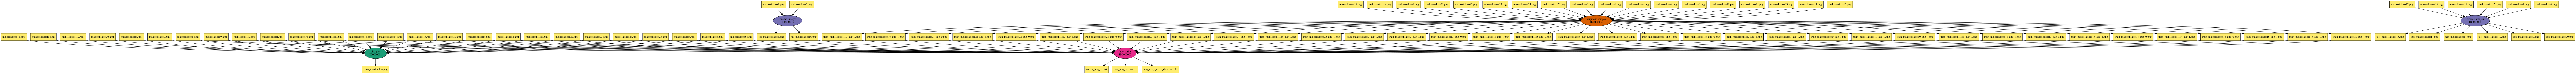

In [17]:
from IPython.display import Image
Image(filename='mask_detection.png')